# Import dependencies

In [133]:
import pandas as pd
from influxdb_client import InfluxDBClient

# Find R2D sessions

In [134]:
# Fetch the data from the InfluxDB
data_file_path = "../../data/ariane.csv"

token = "cCtyspyt-jeehwf5Ayz5OmaOXnvkMj46z3C6UQlud4s8MiPZLFaFuM7z1Y_qqpmVyI5cvF4h9k-kl5dCiYmWFw=="
org = "racingteam"

query_r2d = """from(bucket:"ariane") 
|> range(start: 2023-10-05T00:00:00Z, stop: 2023-10-06T00:00:00Z)
|> filter(fn: (r) => r["_measurement"] == "MISC")
|> filter(fn: (r) => r["_field"] == "FSM")
|> filter(fn: (r) => r["_value"] == "R2D")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
|> drop(columns: ["_start", "_stop"])
|> yield(name: "max")
"""


with InfluxDBClient(url="https://epfl-rt-data-logging.epfl.ch:8443", token=token, org=org) as client:
    df_r2d = client.query_api().query_data_frame(query=query_r2d, org=org)
    df_r2d.drop(columns=["result", "table"], inplace=True)
    df_r2d.set_index("_time", inplace=True)        

In [152]:
threshold = pd.Timedelta(seconds=10)
separation_indexes = df_r2d.index[df_r2d.index.to_series().diff() > threshold].tolist()
separation_indexes = [df_r2d.index[0]] + separation_indexes + [df_r2d.index[-1]]
dfs = [df_r2d.loc[separation_indexes[i]:separation_indexes[i + 1]] for i in range(len(separation_indexes) - 1)]
dfs = [df[:-1] for df in dfs]

date_format = "%Y-%m-%dT%H:%M:%SZ"
dfs_options = [f"range(start: {df.index[0].strftime(date_format)}, stop: {df.index[-1].strftime(date_format)})" for df in dfs]
dfs_elapsed_time = [str((df.index[-1] - df.index[0]).floor('s') )for df in dfs]
dfs_elapsed_time

['0 days 00:00:11',
 '0 days 00:02:17',
 '0 days 00:04:57',
 '0 days 00:02:37',
 '0 days 00:03:32',
 '0 days 00:02:58']

In [136]:
# Get the data
session_choice = 2
date_string = list(dfs_options[session_choice])
date_string[10] = 'T'
date_string = "".join(date_string)
query = f"""from(bucket:"ariane")
|> {dfs_options[session_choice]}
|> filter(fn: (r) => r["_measurement"] == "sensors")
|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""

with InfluxDBClient(url="https://epfl-rt-data-logging.epfl.ch:8443", token=token, org=org) as client:
    df = client.query_api().query_data_frame(query=query, org=org)
    df.drop(columns=["result", "table"], inplace=True)
    df.set_index("_time", inplace=True)    
    df.to_csv(data_file_path)

In [137]:
# Load the data
df = pd.read_csv(data_file_path, index_col=0, parse_dates=True)
df

,_start,_stop,_measurement,AIn1,AIn2,APPS_L_PC,APPS_R_PC,APPS_Travel,BP_1_R,BP_2_F,...,gyroY,gyroZ,solution_status,steering_angle,vX,vXEst,vY,vYEst,vZ,yawRateEst
_time,,,,,,,,,,,,,,,,,,,,,
2023-10-05 17:00:46.006963+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.980335,0.986410,...,-0.002,0.000,0,42.360199,0.00,-0.017932,0.08,0.085445,-9.79,0.0
2023-10-05 17:00:46.016966+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.981295,0.986410,...,0.000,0.000,0,42.195499,-0.07,-0.017996,0.12,0.085575,-9.29,0.0
2023-10-05 17:00:46.029768+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.978418,0.987051,...,-0.004,0.000,0,42.079601,-0.05,-0.018043,0.13,0.085520,-10.06,0.0
2023-10-05 17:00:46.039547+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.980017,0.987370,...,-0.001,0.000,0,42.213799,0.01,-0.017982,0.10,0.085316,-9.46,0.0
2023-10-05 17:00:46.049494+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.980656,0.988968,...,0.000,0.000,0,42.280899,-0.01,-0.017936,0.16,0.085237,-9.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-05 17:05:42.957297+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.979378,0.988010,...,-0.004,0.000,0,-20.225800,-0.07,0.002434,-0.22,0.044923,-10.17,0.0
2023-10-05 17:05:42.970052+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.979696,0.986092,...,-0.004,0.000,0,-20.055000,0.03,-0.001165,-0.24,0.042450,-10.10,0.0
2023-10-05 17:05:42.977291+00:00,2023-10-05 17:00:46+00:00,2023-10-05 17:05:43+00:00,sensors,0,0,0.0,0.0,0.0,0.980976,0.986092,...,0.001,0.000,0,-19.908600,0.05,-0.004531,-0.25,0.039500,-9.29,0.0


array([<Axes: xlabel='_time'>, <Axes: xlabel='_time'>], dtype=object)

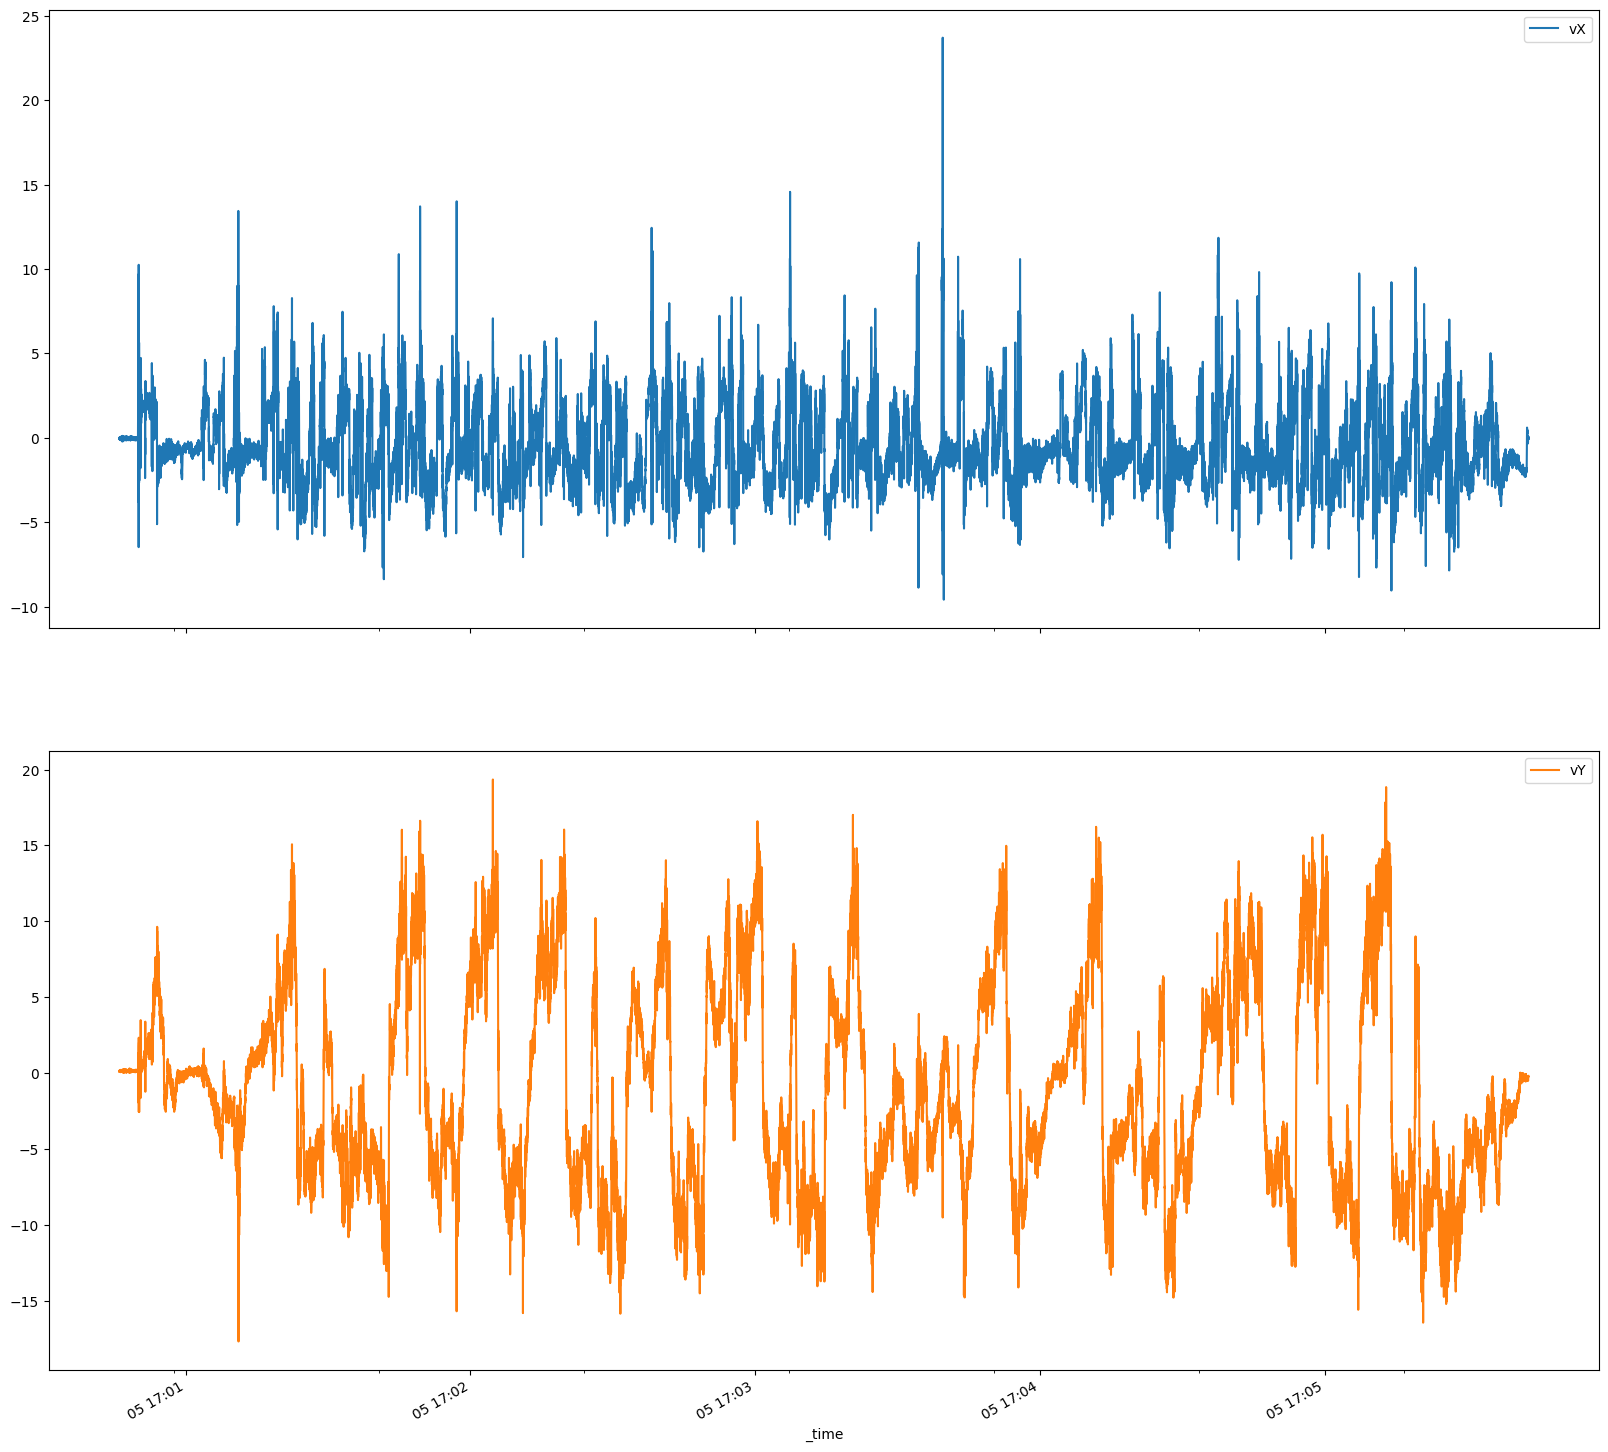

In [138]:
# Plot the data
columns = ["vX", "vY"]
df[columns].plot(subplots=True, figsize=(20, 20))